# CS2 Map Outcome Prediction

This notebook implements machine learning models to predict CS2 professional match outcomes at the map level.

**Dataset**: `map_picks_last6m_top50_ml_ready.csv` (2,412 rows × 20 columns)

**Task**: Binary classification to predict `winner_is_A` (1 if team_A wins, 0 otherwise)

**Models**: Logistic Regression, Random Forest, XGBoost, LightGBM, MLP

**Evaluation**: Accuracy, F1-score, ROC-AUC, Brier score, feature importance

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, brier_score_loss
)
import xgboost as xgb
import lightgbm as lgb
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 85
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load and explore the dataset
DATA_PATH = 'map_picks_last6m_top50_ml_ready.csv'
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['winner_is_A'].value_counts(normalize=True))
print(f"\nSplit distribution:")
print(df['split_row'].value_counts())

# Display first few rows
print(f"\nFirst 3 rows:")
df.head(3)

Dataset shape: (2412, 20)

Columns: ['match_id', 'date', 'map', 'map_number', 'team_A', 'team_B', 'winner', 'team_A_rank', 'team_B_rank', 'rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'winner_is_A', 'split_row', 'split_match']

Target distribution:
winner_is_A
1    0.543118
0    0.456882
Name: proportion, dtype: float64

Split distribution:
split_row
train    1688
test      363
val       361
Name: count, dtype: int64

First 3 rows:


,match_id,date,map,map_number,team_A,team_B,winner,team_A_rank,team_B_rank,rank_diff,abs_rank_diff,picked_by_is_A,is_decider,map_winrate_A,map_winrate_B,recent_form_A,recent_form_B,winner_is_A,split_row,split_match
0,84325,2025-03-25,Mirage,4,B8,Nemiga,B8,23,41,-18,18,1,0,0.5,0.5,0.5,0.5,1,train,train
1,76944,2025-03-25,Train,7,TYLOO,Rare Atom,TYLOO,9,36,-27,27,0,1,0.5,0.5,0.5,0.5,1,train,train
2,84325,2025-03-25,Inferno,7,B8,Nemiga,B8,23,41,-18,18,0,1,0.5,0.5,1.0,0.0,1,train,train


In [3]:
# Define features and target
# Features to use for prediction (excluding match_id, date, team names, winner, splits)
# NOTE: removed 'map_number', 'team_A_rank', 'team_B_rank' from the feature set per user request
feature_cols = [
    'map', 'rank_diff', 'abs_rank_diff',
    'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 
    'recent_form_A', 'recent_form_B'
]

target_col = 'winner_is_A'

# Separate categorical and numerical features
categorical_features = ['map']
numerical_features = [col for col in feature_cols if col not in categorical_features]

print(f"Features to use: {len(feature_cols)}")
print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"\nFeature data types:")
for col in feature_cols:
    print(f"  {col}: {df[col].dtype}")

Features to use: 9
Categorical features: ['map']
Numerical features: ['rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B']

Feature data types:
  map: object
  rank_diff: int64
  abs_rank_diff: int64
  picked_by_is_A: int64
  is_decider: int64
  map_winrate_A: float64
  map_winrate_B: float64
  recent_form_A: float64
  recent_form_B: float64


In [4]:
# Create train/validation/test splits based on existing split_row column
X = df[feature_cols].copy()
y = df[target_col].copy()

# Use existing splits
train_mask = df['split_row'] == 'train'
val_mask = df['split_row'] == 'val'
test_mask = df['split_row'] == 'test'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train set: {X_train.shape[0]} samples ({y_train.mean():.3f} positive rate)")
print(f"Validation set: {X_val.shape[0]} samples ({y_val.mean():.3f} positive rate)")
print(f"Test set: {X_test.shape[0]} samples ({y_test.mean():.3f} positive rate)")

# Check for missing values
print(f"\nMissing values in features:")
print(X_train.isnull().sum().sum())

Train set: 1688 samples (0.542 positive rate)
Validation set: 361 samples (0.568 positive rate)
Test set: 363 samples (0.523 positive rate)

Missing values in features:
0


In [5]:
# Create preprocessing pipeline
# One-hot encode categorical features and standardize numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Fit preprocessor on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(num_feature_names) + list(cat_feature_names)

print(f"Features after preprocessing: {X_train_processed.shape[1]}")
print(f"Feature names: {all_feature_names}")

Features after preprocessing: 15
Feature names: ['rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'map_Anubis', 'map_Dust2', 'map_Inferno', 'map_Mirage', 'map_Nuke', 'map_Overpass', 'map_Train']


In [6]:
# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'MLP': MLPClassifier(random_state=RANDOM_STATE, max_iter=500)
}

# Train baseline models and store results
baseline_results = {}
trained_models = {}

print("Training baseline models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_processed, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_val_processed)
    y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    brier = brier_score_loss(y_val, y_pred_proba)
    
    baseline_results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1,
        'roc_auc': roc_auc,
        'brier_score': brier
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-macro: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Brier Score: {brier:.4f}")

Training baseline models...

Training Logistic Regression...
  Accuracy: 0.5900
  F1-macro: 0.5660
  ROC-AUC: 0.6100
  Brier Score: 0.2368

Training Random Forest...
  Accuracy: 0.5679
  F1-macro: 0.5543
  ROC-AUC: 0.5620
  Brier Score: 0.2540

Training XGBoost...
  Accuracy: 0.5235
  F1-macro: 0.5086
  ROC-AUC: 0.5269
  Brier Score: 0.3094

Training LightGBM...
  Accuracy: 0.5679
  F1-macro: 0.5543
  ROC-AUC: 0.5620
  Brier Score: 0.2540

Training XGBoost...
  Accuracy: 0.5235
  F1-macro: 0.5086
  ROC-AUC: 0.5269
  Brier Score: 0.3094

Training LightGBM...
  Accuracy: 0.5568
  F1-macro: 0.5410
  ROC-AUC: 0.5212
  Brier Score: 0.2835

Training MLP...
  Accuracy: 0.5568
  F1-macro: 0.5410
  ROC-AUC: 0.5212
  Brier Score: 0.2835

Training MLP...
  Accuracy: 0.5374
  F1-macro: 0.5291
  ROC-AUC: 0.5365
  Brier Score: 0.2851
  Accuracy: 0.5374
  F1-macro: 0.5291
  ROC-AUC: 0.5365
  Brier Score: 0.2851


In [7]:
# Hyperparameter tuning
print("Starting hyperparameter tuning...")

# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [15, 31, 63]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
}

# Perform hyperparameter tuning
tuned_results = {}
best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    
    # Use RandomizedSearchCV for efficiency
    search = RandomizedSearchCV(
        model, param_grids[name], 
        n_iter=20,  # Reduced for faster execution
        cv=3, 
        scoring='roc_auc', 
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Fit on training data
    search.fit(X_train_processed, y_train)
    best_models[name] = search.best_estimator_
    
    # Evaluate on validation set
    y_pred = search.predict(X_val_processed)
    y_pred_proba = search.predict_proba(X_val_processed)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    brier = brier_score_loss(y_val, y_pred_proba)
    
    tuned_results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        'best_params': search.best_params_
    }
    
    print(f"  Best params: {search.best_params_}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-macro: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Brier Score: {brier:.4f}")

Starting hyperparameter tuning...

Tuning Logistic Regression...
  Best params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
  Accuracy: 0.5900
  F1-macro: 0.5647
  ROC-AUC: 0.6140
  Brier Score: 0.2363

Tuning Random Forest...
  Best params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
  Accuracy: 0.5900
  F1-macro: 0.5647
  ROC-AUC: 0.6140
  Brier Score: 0.2363

Tuning Random Forest...
  Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
  Accuracy: 0.5956
  F1-macro: 0.5612
  ROC-AUC: 0.6020
  Brier Score: 0.2390

Tuning XGBoost...
  Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
  Accuracy: 0.5956
  F1-macro: 0.5612
  ROC-AUC: 0.6020
  Brier Score: 0.2390

Tuning XGBoost...
  Best params: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
  Accuracy: 0.6039
  F1-macro: 0.5565
  ROC-AUC: 0.6140
  Brier Score: 0.2378

Tuning LightGBM...
  Best para

In [8]:
# Compare baseline vs tuned results
comparison_df = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Baseline_Accuracy': [baseline_results[m]['accuracy'] for m in baseline_results.keys()],
    'Tuned_Accuracy': [tuned_results[m]['accuracy'] for m in tuned_results.keys()],
    'Baseline_F1': [baseline_results[m]['f1_macro'] for m in baseline_results.keys()],
    'Tuned_F1': [tuned_results[m]['f1_macro'] for m in tuned_results.keys()],
    'Baseline_ROC_AUC': [baseline_results[m]['roc_auc'] for m in baseline_results.keys()],
    'Tuned_ROC_AUC': [tuned_results[m]['roc_auc'] for m in tuned_results.keys()],
    'Baseline_Brier': [baseline_results[m]['brier_score'] for m in baseline_results.keys()],
    'Tuned_Brier': [tuned_results[m]['brier_score'] for m in tuned_results.keys()]
})

print("Model Comparison (Baseline vs Tuned):")
print(comparison_df.round(4))

# Find best model based on ROC-AUC
best_model_name = max(tuned_results.keys(), key=lambda x: tuned_results[x]['roc_auc'])
print(f"\nBest model: {best_model_name} (ROC-AUC: {tuned_results[best_model_name]['roc_auc']:.4f})")

Model Comparison (Baseline vs Tuned):
                 Model  Baseline_Accuracy  Tuned_Accuracy  Baseline_F1  \
0  Logistic Regression             0.5900          0.5900       0.5660   
1        Random Forest             0.5679          0.5956       0.5543   
2              XGBoost             0.5235          0.6039       0.5086   
3             LightGBM             0.5568          0.5651       0.5410   
4                  MLP             0.5374          0.5374       0.5291   

   Tuned_F1  Baseline_ROC_AUC  Tuned_ROC_AUC  Baseline_Brier  Tuned_Brier  
0    0.5647            0.6100         0.6140          0.2368       0.2363  
1    0.5612            0.5620         0.6020          0.2540       0.2390  
2    0.5565            0.5269         0.6140          0.3094       0.2378  
3    0.5402            0.5212         0.5507          0.2835       0.2536  
4    0.4755            0.5365         0.5189          0.2851       0.2868  

Best model: Logistic Regression (ROC-AUC: 0.6140)


In [9]:
# === 4b) GroupKFold hyperparameter tuning + calibration (by match_id)
print('Running GroupKFold hyperparameter tuning and calibration by match_id...')
from sklearn.model_selection import GroupKFold
from sklearn.calibration import CalibratedClassifierCV

# Prepare group-aware CV
group_cv = GroupKFold(n_splits=3)
groups_train = df.loc[train_mask, 'match_id']

models_to_group_tune = {
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
}

param_grids_group = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [15, 31, 63],
    },
}

group_tuned_results = {}
calibrated_models = {}

for name, base_model in models_to_group_tune.items():
    print(f"\nTuning (GroupKFold) {name}...")
    grid = param_grids_group[name]
    search = RandomizedSearchCV(base_model, grid, n_iter=20, cv=group_cv, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1)
    # Fit with groups to ensure group-aware CV
    search.fit(X_train_processed, y_train, groups=groups_train)
    best = search.best_estimator_
    print('  Best params:', search.best_params_)

    # Ensure best is fitted on full training data
    try:
        best.fit(X_train_processed, y_train)
    except Exception:
        pass

    # Calibrate on validation set (prefit required)
    try:
        calibrated = CalibratedClassifierCV(best, cv='prefit', method='sigmoid')
        calibrated.fit(X_val_processed, y_val)
        calibrated_models[name] = calibrated
    except Exception as e:
        print('  Calibration failed or not applicable, using uncalibrated model:', e)
        calibrated_models[name] = best

    # Evaluate on test set
    model_for_test = calibrated_models[name]
    if hasattr(model_for_test, 'predict_proba'):
        y_pred_proba = model_for_test.predict_proba(X_test_processed)[:, 1]
    else:
        try:
            y_pred_proba = model_for_test.decision_function(X_test_processed)
        except Exception:
            y_pred_proba = model_for_test.predict(X_test_processed)
    y_pred = model_for_test.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except Exception:
        roc_auc = float('nan')
    try:
        brier = brier_score_loss(y_test, y_pred_proba)
    except Exception:
        brier = float('nan')

    group_tuned_results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        'best_params': search.best_params_,
    }
    print(f'  Test Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, Brier: {brier:.4f}')

    # Save calibrated model
    if not os.path.exists('models'):
        os.makedirs('models')
    model_filename = f"models/{name.lower().replace(' ', '_')}_group_calibrated.pkl"
    joblib.dump(calibrated_models[name], model_filename)
    print('  Saved calibrated model to', model_filename)

print('\nGroupKFold tuning + calibration complete. Results:')
print(group_tuned_results)

# Merge calibrated models into best_models for downstream analysis
for k, v in calibrated_models.items():
    best_models[k] = v

print('Proceeding to final evaluation with calibrated models...')

# Final evaluation on test set using best models
print('Final evaluation on test set:')
print('='*50)
test_results = {}
for name, model in best_models.items():
    try:
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_processed)
    except Exception:
        y_pred_proba = model.predict(X_test_processed)
    y_pred = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except Exception:
        roc_auc = float('nan')
    try:
        brier = brier_score_loss(y_test, y_pred_proba)
    except Exception:
        brier = float('nan')

    test_results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        'predictions': y_pred,
        'probabilities': y_pred_proba if isinstance(y_pred_proba, (list, np.ndarray)) else np.array(y_pred_proba)
    }
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-macro: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Brier Score: {brier:.4f}")

# Create final results summary
final_results_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Test_Accuracy': [test_results[m]['accuracy'] for m in test_results.keys()],
    'Test_F1_Macro': [test_results[m]['f1_macro'] for m in test_results.keys()],
    'Test_ROC_AUC': [test_results[m]['roc_auc'] for m in test_results.keys()],
    'Test_Brier_Score': [test_results[m]['brier_score'] for m in test_results.keys()]
})
print('\n' + '='*50)
print('FINAL TEST RESULTS:')
print(final_results_df.round(4))

Running GroupKFold hyperparameter tuning and calibration by match_id...

Tuning (GroupKFold) Random Forest...
  Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5}
  Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5}
  Test Accuracy: 0.5840, ROC-AUC: 0.6090, Brier: 0.2425
  Saved calibrated model to models/random_forest_group_calibrated.pkl

Tuning (GroupKFold) XGBoost...
  Test Accuracy: 0.5840, ROC-AUC: 0.6090, Brier: 0.2425
  Saved calibrated model to models/random_forest_group_calibrated.pkl

Tuning (GroupKFold) XGBoost...
  Best params: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
  Test Accuracy: 0.5950, ROC-AUC: 0.6072, Brier: 0.2421
  Saved calibrated model to models/xgboost_group_calibrated.pkl

Tuning (GroupKFold) LightGBM...
  Best params: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
  Test Accuracy: 0.5950, ROC-AUC: 0

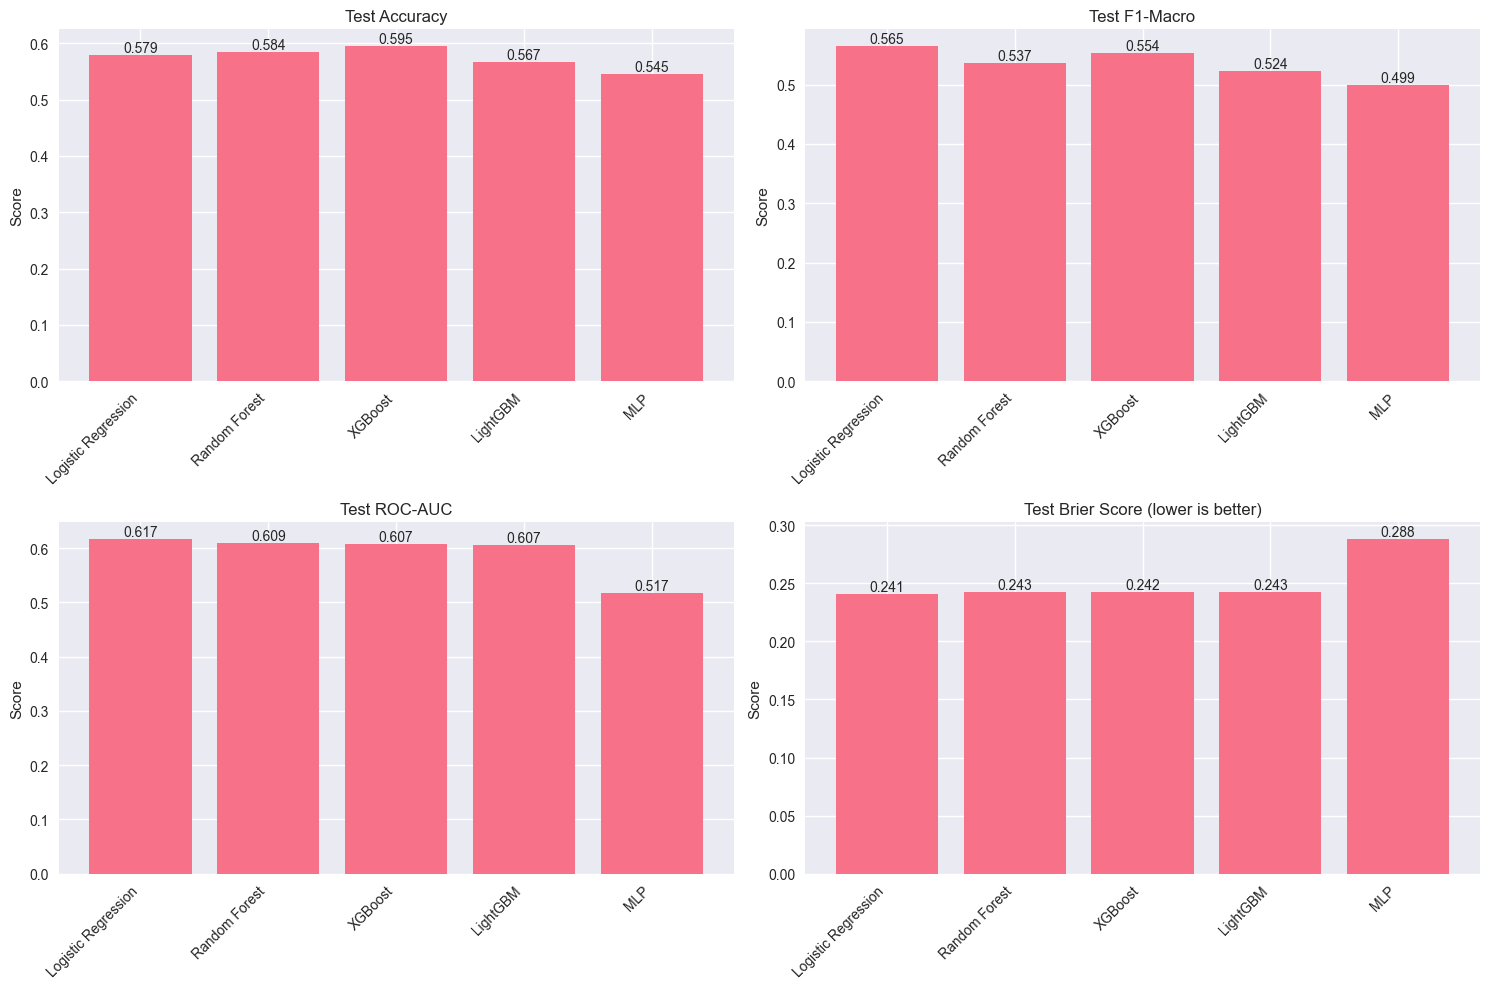

In [10]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Test_Accuracy', 'Test_F1_Macro', 'Test_ROC_AUC', 'Test_Brier_Score']
titles = ['Test Accuracy', 'Test F1-Macro', 'Test ROC-AUC', 'Test Brier Score (lower is better)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]
    bars = ax.bar(final_results_df['Model'], final_results_df[metric])
    ax.set_title(title)
    ax.set_ylabel('Score')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

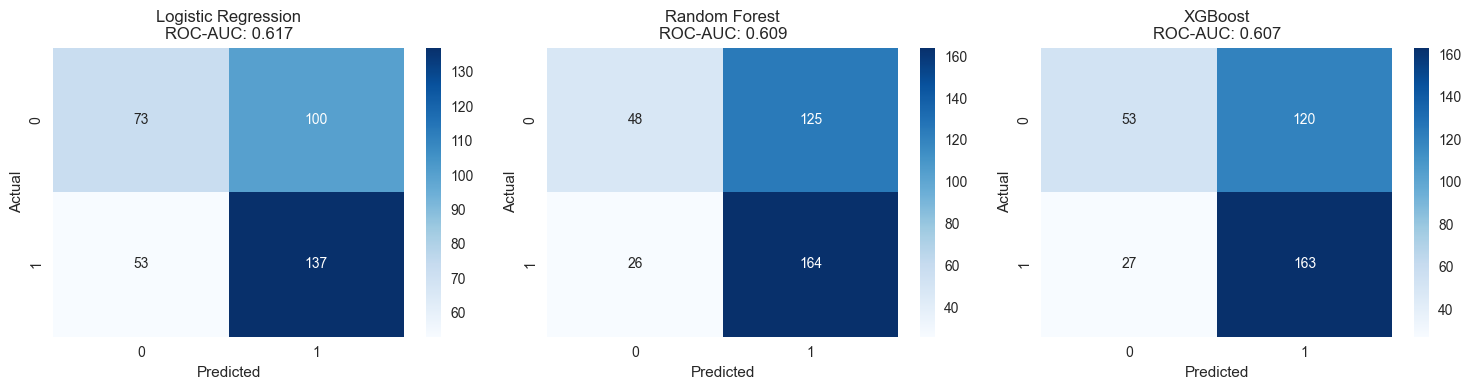

In [13]:
# Confusion matrices for best performing models
# Select top 3 models by ROC-AUC
top_3_models = sorted(test_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, results) in enumerate(top_3_models):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nROC-AUC: {results["roc_auc"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

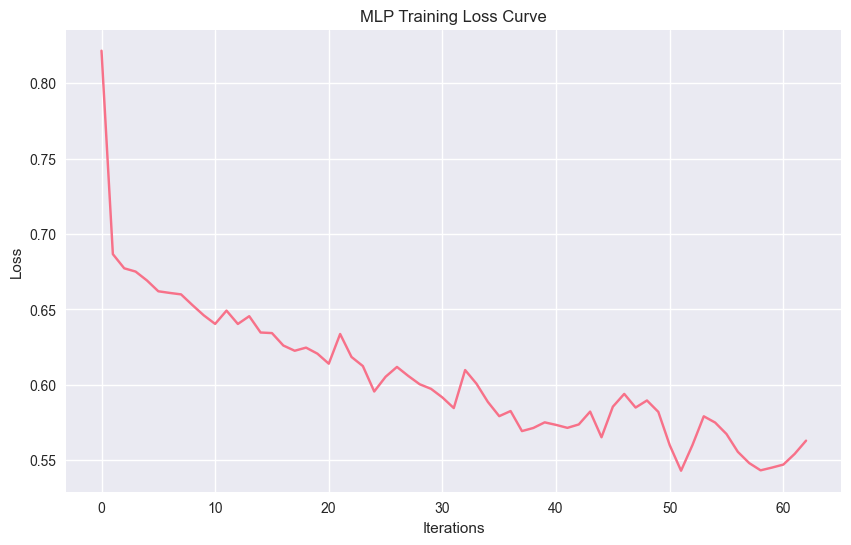

In [14]:
# Training history for MLP (if available)
mlp_model = best_models['MLP']
if hasattr(mlp_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_model.loss_curve_)
    plt.title('MLP Training Loss Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
else:
    print("MLP loss curve not available")

In [15]:
# Save models and results
if not os.path.exists('models'):
    os.makedirs('models')

print("Saving trained models and results...")

# Save best models
for name, model in best_models.items():
    model_filename = f"models/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_filename)
    print(f"Saved {name} to {model_filename}")

# Save preprocessor
joblib.dump(preprocessor, 'models/preprocessor.pkl')
print("Saved preprocessor to models/preprocessor.pkl")

# Save results
results_summary = {
    'dataset_info': {
        'total_samples': len(df),
        'features': feature_cols,
        'target': target_col,
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test)
    },
    'baseline_results': baseline_results,
    'tuned_results': tuned_results,
    'final_test_results': {name: {k: v for k, v in results.items() if k not in ['predictions', 'probabilities']} 
                          for name, results in test_results.items()},
    'best_model': best_model_name,
    'feature_names': all_feature_names
}

with open('models/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)
print("Saved results summary to models/results_summary.json")

Saving trained models and results...
Saved Logistic Regression to models/logistic_regression_model.pkl
Saved Random Forest to models/random_forest_model.pkl
Saved XGBoost to models/xgboost_model.pkl
Saved LightGBM to models/lightgbm_model.pkl
Saved MLP to models/mlp_model.pkl
Saved preprocessor to models/preprocessor.pkl
Saved results summary to models/results_summary.json


In [16]:
# === 1) Add Elo features (chronological, map-agnostic and map-specific)
from collections import defaultdict

print('Computing Elo (map-agnostic and map-specific) features...')
K = 20
init_elo = 1500
scale = 400

# Ensure date is datetime and sort chronologically
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date').copy()

team_elo = defaultdict(lambda: init_elo)
team_map_elo = defaultdict(lambda: defaultdict(lambda: init_elo))

elo_A_list, elo_B_list, map_elo_A_list, map_elo_B_list = [], [], [], []

for idx, row in df_sorted.iterrows():
    a = row['team_A']
    b = row['team_B']
    m = row['map']

    ea = team_elo[a]
    eb = team_elo[b]
    ema = team_map_elo[a][m]
    emb = team_map_elo[b][m]

    # record current ratings as features
    elo_A_list.append(ea)
    elo_B_list.append(eb)
    map_elo_A_list.append(ema)
    map_elo_B_list.append(emb)

    # expected probabilities
    p_a = 1.0 / (1.0 + 10 ** ((eb - ea) / scale))
    p_map_a = 1.0 / (1.0 + 10 ** ((emb - ema) / scale))

    # actual outcome (team A win = 1 else 0)
    outcome = 1 if row['winner'] == a else 0

    # update global and map-specific elos
    team_elo[a] += K * (outcome - p_a)
    team_elo[b] += K * ((1 - outcome) - (1 - p_a))

    team_map_elo[a][m] += K * (outcome - p_map_a)
    team_map_elo[b][m] += K * ((1 - outcome) - (1 - p_map_a))

# Assign features back to dataframe in the original index order
df.loc[df_sorted.index, 'elo_A'] = elo_A_list
df.loc[df_sorted.index, 'elo_B'] = elo_B_list
df.loc[df_sorted.index, 'map_elo_A'] = map_elo_A_list
df.loc[df_sorted.index, 'map_elo_B'] = map_elo_B_list

print('Elo features added: elo_A, elo_B, map_elo_A, map_elo_B')


Computing Elo (map-agnostic and map-specific) features...
Elo features added: elo_A, elo_B, map_elo_A, map_elo_B


In [17]:
# === 2) Add head-to-head and last-5 map-specific recent form features
from collections import deque

print('Computing head-to-head and last-5 map stats...')

h2h_wins = defaultdict(lambda: {'wins': 0, 'total': 0})
team_map_deque = defaultdict(lambda: defaultdict(lambda: deque(maxlen=5)))

h2h_rate_list = []
last5_map_rate_A = []
last5_map_rate_B = []

for idx, row in df_sorted.iterrows():
    a = row['team_A']
    b = row['team_B']
    m = row['map']

    # head-to-head rate for A vs B
    key = (a, b)
    record = h2h_wins[key]
    h2h_rate = record['wins'] / record['total'] if record['total'] > 0 else 0.5
    h2h_rate_list.append(h2h_rate)

    # last-5 map rates
    qa = team_map_deque[a][m]
    qb = team_map_deque[b][m]
    last5_map_rate_A.append(sum(qa) / len(qa) if len(qa) > 0 else 0.5)
    last5_map_rate_B.append(sum(qb) / len(qb) if len(qb) > 0 else 0.5)

    # update outcomes after recording
    outcome = 1 if row['winner'] == a else 0
    h2h_wins[(a, b)]['wins'] += outcome
    h2h_wins[(a, b)]['total'] += 1
    h2h_wins[(b, a)]['wins'] += (1 - outcome)
    h2h_wins[(b, a)]['total'] += 1

    # update recent map queues
    team_map_deque[a][m].append(outcome)
    team_map_deque[b][m].append(1 - outcome)

# write back to df
df.loc[df_sorted.index, 'h2h_rate_A_vs_B'] = h2h_rate_list
df.loc[df_sorted.index, 'last5_map_rate_A'] = last5_map_rate_A
df.loc[df_sorted.index, 'last5_map_rate_B'] = last5_map_rate_B

print('Added features: h2h_rate_A_vs_B, last5_map_rate_A, last5_map_rate_B')


Computing head-to-head and last-5 map stats...
Added features: h2h_rate_A_vs_B, last5_map_rate_A, last5_map_rate_B


In [18]:
# === 3) Update feature list & preprocessing to include new features
print('Updating feature list to include new features and re-running preprocessing...')

# Append new features to feature list
new_features = ['elo_A','elo_B','map_elo_A','map_elo_B','h2h_rate_A_vs_B','last5_map_rate_A','last5_map_rate_B']
for nf in new_features:
    if nf not in feature_cols:
        feature_cols.append(nf)

# Recompute numerical/categorical splits
categorical_features = ['map']
numerical_features = [c for c in feature_cols if c not in categorical_features]

print('New feature count:', len(feature_cols))
print('Numerical features:', numerical_features)

# IMPORTANT: Refresh X and y from the updated dataframe so new columns are included
X = df[feature_cols].copy()
y = df[target_col].copy()

# Recompute masks in case they were changed earlier
train_mask = df['split_row'] == 'train'
val_mask = df['split_row'] == 'val'
test_mask = df['split_row'] == 'test'

# Re-split data
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Re-fit preprocessor and transform datasets
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Update feature names after preprocessing
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(num_feature_names) + list(cat_feature_names)
print('Processed feature count:', X_train_processed.shape[1])


Updating feature list to include new features and re-running preprocessing...
New feature count: 16
Numerical features: ['rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'elo_A', 'elo_B', 'map_elo_A', 'map_elo_B', 'h2h_rate_A_vs_B', 'last5_map_rate_A', 'last5_map_rate_B']
Processed feature count: 22


In [19]:
# === 3b) Add interaction features, map metadata, and fold-safe target encodings
print('Adding interaction features, map metadata, and target encodings (train-fold safe)...')
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])
# Interaction/diff features
df['elo_diff'] = df['elo_A'] - df['elo_B']
df['map_elo_diff'] = df['map_elo_A'] - df['map_elo_B']
df['last5_map_diff'] = df['last5_map_rate_A'] - df['last5_map_rate_B']
df['h2h_diff'] = df['h2h_rate_A_vs_B'] - 0.5
df['h2h_raw'] = df['h2h_rate_A_vs_B']
# Compute map counts and map first seen from training data (avoid leakage)
train_map_counts = df[train_mask].groupby('map').size().to_dict()
map_first_seen = df[train_mask].groupby('map')['date'].min().to_dict()
df['map_count_train'] = df['map'].map(train_map_counts).fillna(0).astype(int)
df['map_first_seen_train'] = df['map'].map(map_first_seen)
df['map_age_days'] = (df['date'] - df['map_first_seen_train']).dt.days.fillna(9999).astype(int)
df['new_map_flag'] = ((df['map_count_train'] < 50) | (df['map_age_days'] < 30)).astype(int)
# Fold-safe team target encoding using training set only
global_winrate = df[train_mask][target_col].mean()
m_smooth = 5.0
# Build winner_team column for train set
train_rows = df[train_mask].copy()
train_rows['winner_team'] = train_rows.apply(lambda r: r['team_A'] if r[target_col]==1 else r['team_B'], axis=1)
team_wins = train_rows['winner_team'].value_counts().to_dict()
team_counts_A = df[train_mask]['team_A'].value_counts().to_dict()
team_counts_B = df[train_mask]['team_B'].value_counts().to_dict()
# total matches per team in train (as either A or B)
team_matches = {}
for t, c in {**team_counts_A, **team_counts_B}.items():
    team_matches[t] = team_matches.get(t, 0) + c
team_wins_total = team_wins
# compute smoothed win rate per team
team_smoothed = {}
for t in set(list(team_matches.keys()) + list(team_wins_total.keys())):
    wins = team_wins_total.get(t, 0)
    cnt = team_matches.get(t, 0)
    team_smoothed[t] = (wins + m_smooth * global_winrate) / (cnt + m_smooth) if cnt>0 else global_winrate
# map to df for team_A and team_B
df['team_A_te'] = df['team_A'].map(team_smoothed).fillna(global_winrate)
df['team_B_te'] = df['team_B'].map(team_smoothed).fillna(global_winrate)
# Append new features to feature list if not present
extra_feats = ['elo_diff','map_elo_diff','last5_map_diff','h2h_diff','h2h_raw','map_count_train','map_age_days','new_map_flag','team_A_te','team_B_te']
for ef in extra_feats:
    if ef not in feature_cols:
        feature_cols.append(ef)
print('Appended extra features. Total features now:', len(feature_cols))
# Recompute numerical/categorical splits and re-fit preprocessor
categorical_features = ['map']
numerical_features = [c for c in feature_cols if c not in categorical_features]
X = df[feature_cols].copy()
y = df[target_col].copy()
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(num_feature_names) + list(cat_feature_names)
print('Processed features count:', X_train_processed.shape[1])

# === 4) Error analysis: per-map and per-team error rates on validation set
print('Running error analysis on validation set...')

# Use tuned best_models if available else trained_models
models_to_eval = best_models if 'best_models' in globals() and best_models else trained_models

error_report = {}

# Helper: ensure a model can accept the current features; if not, refit on X_train_processed
def ensure_model_compat(model, X_train_proc, y_train):
    try:
        expected = getattr(model, 'n_features_in_', None)
        if expected is None:
            # model hasn't been fitted or doesn't expose n_features_in_; try a quick fit
            model.fit(X_train_proc, y_train)
            return model
        if expected != X_train_proc.shape[1]:
            print(f'Model expects {expected} features but current data has {X_train_proc.shape[1]}; refitting model on current training data')
            model.fit(X_train_proc, y_train)
    except Exception as e:
        print('Warning: could not check/refit model automatically:', e)
    return model

for name, model in models_to_eval.items():
    # Ensure compatibility between model and processed features
    model = ensure_model_compat(model, X_train_processed, y_train)

    # Now safely predict on validation set
    try:
        y_pred = model.predict(X_val_processed)
    except Exception as e:
        print(f'Failed to predict with model {name}: {e} -- skipping')
        continue

    df_val = df[val_mask].copy()
    df_val['pred'] = y_pred
    df_val['correct'] = (df_val['pred'] == df_val['winner_is_A']).astype(int)

    # Per-map error rates
    per_map = df_val.groupby('map')['correct'].agg(['mean','count']).rename(columns={'mean':'accuracy'})
    per_map['error_rate'] = 1 - per_map['accuracy']

    # Per-team error rates (team_A perspective)
    per_team_A = df_val.groupby('team_A')['correct'].agg(['mean','count']).rename(columns={'mean':'accuracy_A'})
    per_team_A['error_rate_A'] = 1 - per_team_A['accuracy_A']

    error_report[name] = {
        'per_map': per_map.sort_values('error_rate', ascending=False).head(10).to_dict(),
        'per_team_A': per_team_A.sort_values('error_rate_A', ascending=False).head(10).to_dict()
    }

# Save error report
with open('phase2_error_report.json', 'w') as f:
    json.dump(error_report, f, indent=2, default=str)

print('Error report saved to phase2_error_report.json')

# Show top failing maps for the first available model
if len(models_to_eval) > 0 and len(error_report) > 0:
    first_model = next(iter(error_report))
    print('\nTop failing maps for model:', first_model)
    print(pd.DataFrame(error_report[first_model]['per_map']).T.head(10))


Adding interaction features, map metadata, and target encodings (train-fold safe)...
Appended extra features. Total features now: 26
Processed features count: 32
Running error analysis on validation set...
Model expects 15 features but current data has 32; refitting model on current training data
Model expects 15 features but current data has 32; refitting model on current training data
Model expects 15 features but current data has 32; refitting model on current training data
Model expects 15 features but current data has 32; refitting model on current training data
Model expects 15 features but current data has 32; refitting model on current training data
Error report saved to phase2_error_report.json

Top failing maps for model: Logistic Regression
            Overpass     Mirage       Nuke      Train     Anubis      Dust2  \
accuracy         0.5   0.580645   0.597015   0.607143   0.652174   0.684211   
count           12.0  62.000000  67.000000  28.000000  23.000000  57.000000   
e

In [20]:
# === 5) Per-map specialized models for maps with sufficient data (tuning + calibration)
print('Training and calibrating per-map specialized models for maps with >=50 total samples...')
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

per_map_report = {}
min_total_samples = 50
maps_counts = df['map'].value_counts()
candidate_maps = [m for m, c in maps_counts.items() if c >= min_total_samples]
print('Candidate maps:', candidate_maps)

# Parameter grid for LightGBM (used as default base)
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Helper to build a fresh estimator for per-map training
def build_fresh_estimator(base_name):
    params = {}
    # Prefer tuned params from tuned_results if available
    if 'tuned_results' in globals() and tuned_results.get(base_name):
        params = tuned_results.get(base_name).get('best_params', {})
    if base_name == 'LightGBM':
        return lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, **params)
    if base_name == 'XGBoost':
        return xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', **params)
    if base_name == 'Random Forest':
        return RandomForestClassifier(random_state=RANDOM_STATE, **params)
    return None

# Choose base algorithm name (prefer LightGBM)
base_name = 'LightGBM' if 'LightGBM' in tuned_results else next(iter(tuned_results)) if 'tuned_results' in globals() and tuned_results else None
if base_name is None:
    print('No tuned model parameters available globally; proceeding with LightGBM defaults')
    base_name = 'LightGBM'

for m in candidate_maps:
    print(f'\nProcessing map: {m}')
    map_mask = df['map'] == m
    train_map_mask = map_mask & train_mask
    val_map_mask = map_mask & val_mask
    test_map_mask = map_mask & test_mask

    if train_map_mask.sum() < 30:
        print(f'  Skipping {m}: not enough train samples ({train_map_mask.sum()})')
        continue

    # Build estimator
    per_map_model = build_fresh_estimator(base_name)
    if per_map_model is None:
        print('  Could not build a fresh estimator; skipping')
        continue

    # Extract processed rows for the map using boolean indexing on the train/val/test splits
    try:
        train_idx = np.where(train_mask.values)[0]
        val_idx = np.where(val_mask.values)[0]
        test_idx = np.where(test_mask.values)[0]
        train_map_idx = np.where((df['map'] == m) & train_mask)[0]
        val_map_idx = np.where((df['map'] == m) & val_mask)[0]
        test_map_idx = np.where((df['map'] == m) & test_mask)[0]

        train_positions = [np.where(train_idx == i)[0][0] for i in train_map_idx if i in train_idx]
        val_positions = [np.where(val_idx == i)[0][0] for i in val_map_idx if i in val_idx]
        test_positions = [np.where(test_idx == i)[0][0] for i in test_map_idx if i in test_idx]

        if len(train_positions) == 0:
            print('  No train positions after indexing; skipping')
            continue

        X_train_map_proc = X_train_processed[train_positions]
        y_train_map = y.iloc[train_map_idx].copy()
        X_val_map_proc = X_val_processed[val_positions] if len(val_positions) > 0 else None
        y_val_map = y.iloc[val_map_idx].copy() if len(val_positions) > 0 else None
        X_test_map_proc = X_test_processed[test_positions] if len(test_positions) > 0 else None
        y_test_map = y.iloc[test_map_idx].copy() if len(test_positions) > 0 else None

    except Exception as e:
        print('  Failed to extract processed positions for map:', e)
        continue

    # If there are enough train samples, run a small randomized search on this map
    try:
        print('  Running RandomizedSearchCV for per-map tuning...')
        search = RandomizedSearchCV(
            lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
            lgb_param_grid,
            n_iter=12,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
            scoring='roc_auc',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        search.fit(X_train_map_proc, y_train_map)
        best_pm = search.best_estimator_
        print('  Best params (per-map):', search.best_params_)
    except Exception as e:
        print('  Per-map tuning failed; falling back to default per_map_model:', e)
        best_pm = per_map_model

    # Ensure fitted on full per-map train
    try:
        best_pm.fit(X_train_map_proc, y_train_map)
    except Exception as e:
        print('  Failed to fit per-map model after tuning:', e)
        continue

    # Calibrate: prefer using validation map rows (if available), else use CV calibration
    try:
        if X_val_map_proc is not None and len(y_val_map) > 0:
            calibrated_pm = CalibratedClassifierCV(best_pm, cv='prefit', method='sigmoid')
            calibrated_pm.fit(X_val_map_proc, y_val_map)
            print('  Calibrated per-map model using map validation rows')
        else:
            # Use cross-validation calibration on map train data
            calibrated_pm = CalibratedClassifierCV(best_pm, cv=3, method='sigmoid')
            calibrated_pm.fit(X_train_map_proc, y_train_map)
            print('  Calibrated per-map model using CV on train rows')
    except Exception as e:
        print('  Calibration failed for per-map model; using uncalibrated best estimator:', e)
        calibrated_pm = best_pm

    # Evaluate on map test rows
    if X_test_map_proc is None or len(y_test_map) == 0:
        print('  No test rows for this map; skipping evaluation')
        # Save models anyway
        if not os.path.exists('models'):
            os.makedirs('models')
        joblib.dump(best_pm, f'models/per_map_{m.lower().replace(" ", "_")}_tuned.pkl')
        joblib.dump(calibrated_pm, f'models/per_map_{m.lower().replace(" ", "_")}_calibrated.pkl')
        continue

    y_pred = calibrated_pm.predict(X_test_map_proc)
    try:
        y_proba = calibrated_pm.predict_proba(X_test_map_proc)[:, 1]
    except Exception:
        try:
            y_proba = calibrated_pm.decision_function(X_test_map_proc)
        except Exception:
            y_proba = y_pred

    acc = accuracy_score(y_test_map, y_pred)
    try:
        roc = roc_auc_score(y_test_map, y_proba)
    except Exception:
        roc = float('nan')
    try:
        brier_v = brier_score_loss(y_test_map, y_proba)
    except Exception:
        brier_v = float('nan')

    # Compare to global calibrated model prediction on the same rows (if exists)
    global_model = best_models.get(base_name)
    if global_model is not None:
        try:
            g_pred = global_model.predict(X_test_map_proc)
            try:
                g_proba = global_model.predict_proba(X_test_map_proc)[:, 1]
            except Exception:
                try:
                    g_proba = global_model.decision_function(X_test_map_proc)
                except Exception:
                    g_proba = g_pred
            g_acc = accuracy_score(y_test_map, g_pred)
            try:
                g_roc = roc_auc_score(y_test_map, g_proba)
            except Exception:
                g_roc = float('nan')
            try:
                g_brier = brier_score_loss(y_test_map, g_proba)
            except Exception:
                g_brier = float('nan')
        except Exception as e:
            print('  Global model eval failed:', e)
            g_acc = g_roc = g_brier = float('nan')
    else:
        g_acc = g_roc = g_brier = float('nan')

    per_map_report[m] = {
        'per_map_test_count': int(test_map_mask.sum()),
        'per_map_train_count': int(train_map_mask.sum()),
        'per_map_val_count': int(val_map_mask.sum()),
        'per_map_model': {'accuracy': acc, 'roc_auc': roc, 'brier': brier_v},
        'global_model_on_map': {'accuracy': g_acc, 'roc_auc': g_roc, 'brier': g_brier}
    }

    # Save per-map models
    if not os.path.exists('models'):
        os.makedirs('models')
    tuned_path = f"models/per_map_{m.lower().replace(' ', '_')}_tuned.pkl"
    calibrated_path = f"models/per_map_{m.lower().replace(' ', '_')}_calibrated.pkl"
    joblib.dump(best_pm, tuned_path)
    joblib.dump(calibrated_pm, calibrated_path)
    print(f'  Saved per-map tuned model to {tuned_path}')
    print(f'  Saved per-map calibrated model to {calibrated_path}')

# Save per-map report
with open('per_map_model_report.json', 'w') as f:
    json.dump(per_map_report, f, indent=2, default=str)
print('Saved per-map report to per_map_model_report.json')

Training and calibrating per-map specialized models for maps with >=50 total samples...
Candidate maps: ['Mirage', 'Nuke', 'Dust2', 'Ancient', 'Inferno', 'Train', 'Anubis', 'Overpass']

Processing map: Mirage
  Running RandomizedSearchCV for per-map tuning...
  Best params (per-map): {'num_leaves': 63, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}
  Calibrated per-map model using map validation rows
  Saved per-map tuned model to models/per_map_mirage_tuned.pkl
  Saved per-map calibrated model to models/per_map_mirage_calibrated.pkl

Processing map: Nuke
  Running RandomizedSearchCV for per-map tuning...
  Best params (per-map): {'num_leaves': 63, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}
  Calibrated per-map model using map validation rows
  Saved per-map tuned model to models/per_map_mirage_tuned.pkl
  Saved per-map calibrated model to models/per_map_mirage_calibrated.pkl

Processing map: Nuke
  Running RandomizedSearchCV for per-map tuning...
  Best p

In [21]:
# === 6) Per-map threshold tuning (Youden's J) to reduce 0->1 false positives
print('Running per-map threshold tuning using validation set (Youden J) and evaluating on test set...')
from sklearn.metrics import roc_curve, confusion_matrix
threshold_report = {}

# Load per_map models if available (calibrated preferred, tuned fallback)
import glob
per_map_models = {}
cal_files = glob.glob('models/per_map_*_calibrated.pkl')
tuned_files = glob.glob('models/per_map_*_tuned.pkl')
all_pm_files = cal_files + tuned_files
for p in all_pm_files:
    try:
        base = os.path.basename(p)
        # extract map name: per_map_<map>_calibrated.pkl or per_map_<map>_tuned.pkl
        name = base.replace('per_map_','').replace('_calibrated.pkl','').replace('_tuned.pkl','').replace('.pkl','')
        pretty = name.replace('_',' ').title()
        per_map_models[pretty] = joblib.load(p)
        print('  Loaded per-map model for', pretty, 'from', p)
    except Exception as e:
        print('  Could not load', p, e)

# choose base global model name used earlier
global_base = 'LightGBM' if 'LightGBM' in best_models else next(iter(best_models))
global_model = best_models.get(global_base)

maps_to_check = list(per_map_report.keys()) if 'per_map_report' in globals() else candidate_maps

for m in maps_to_check:
    print('\nMap:', m)
    map_mask = df['map'] == m
    val_map_mask = map_mask & val_mask
    test_map_mask = map_mask & test_mask
    if val_map_mask.sum() == 0 or test_map_mask.sum() == 0:
        print('  Not enough val/test rows; skipping')
        continue

    # validation inputs
    val_idx = np.where(val_mask.values)[0]
    val_map_idx = np.where(val_map_mask.values)[0]
    val_positions = [np.where(val_idx == i)[0][0] for i in val_map_idx if i in val_idx]
    if len(val_positions) == 0:
        print('  No val positions after indexing; skipping')
        continue
    X_val_map_proc = X_val_processed[val_positions]
    y_val_map = y.iloc[val_map_idx].copy()

    # test inputs
    test_idx = np.where(test_mask.values)[0]
    test_map_idx = np.where(test_map_mask.values)[0]
    test_positions = [np.where(test_idx == i)[0][0] for i in test_map_idx if i in test_idx]
    if len(test_positions) == 0:
        print('  No test positions after indexing; skipping')
        continue
    X_test_map_proc = X_test_processed[test_positions]
    y_test_map = y.iloc[test_map_idx].copy()

    threshold_report[m] = {}

    # helper to compute best threshold
    def find_best_threshold(model, X_val, y_val):
        try:
            proba_val = model.predict_proba(X_val)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_val)
        except Exception:
            return 0.5
        if len(np.unique(proba_val)) < 2:
            return 0.5
        fpr, tpr, thresh = roc_curve(y_val, proba_val)
        youden = tpr - fpr
        best_i = np.argmax(youden)
        return float(thresh[best_i])

    # evaluate both global and per-map (if per-map exists)
    # Global model
    try:
        g_thresh = find_best_threshold(global_model, X_val_map_proc, y_val_map)
        try:
            g_proba_test = global_model.predict_proba(X_test_map_proc)[:,1] if hasattr(global_model, 'predict_proba') else global_model.decision_function(X_test_map_proc)
        except Exception:
            g_proba_test = global_model.predict(X_test_map_proc)
        g_pred_test = (g_proba_test >= g_thresh).astype(int)
        g_cm = confusion_matrix(y_test_map, g_pred_test).tolist()
        g_fp = int(g_cm[0][1])
        g_fn = int(g_cm[1][0])
        threshold_report[m]['global'] = {'threshold': g_thresh, 'confusion_matrix': g_cm, 'fp': g_fp, 'fn': g_fn}
        print(f"  Global model: thresh={g_thresh:.3f}, FP={g_fp}, FN={g_fn}")
    except Exception as e:
        print('  Global eval failed:', e)
        threshold_report[m]['global'] = {'error': str(e)}

    # Per-map model
    pm = per_map_models.get(m)
    if pm is not None:
        try:
            pm_thresh = find_best_threshold(pm, X_val_map_proc, y_val_map)
            try:
                pm_proba_test = pm.predict_proba(X_test_map_proc)[:,1] if hasattr(pm, 'predict_proba') else pm.decision_function(X_test_map_proc)
            except Exception:
                pm_proba_test = pm.predict(X_test_map_proc)
            pm_pred_test = (pm_proba_test >= pm_thresh).astype(int)
            pm_cm = confusion_matrix(y_test_map, pm_pred_test).tolist()
            pm_fp = int(pm_cm[0][1])
            pm_fn = int(pm_cm[1][0])
            threshold_report[m]['per_map'] = {'threshold': pm_thresh, 'confusion_matrix': pm_cm, 'fp': pm_fp, 'fn': pm_fn}
            print(f"  Per-map model: thresh={pm_thresh:.3f}, FP={pm_fp}, FN={pm_fn}")
        except Exception as e:
            print('  Per-map eval failed:', e)
            threshold_report[m]['per_map'] = {'error': str(e)}
    else:
        print('  No per-map model loaded for', m)
        threshold_report[m]['per_map'] = {'error': 'no model'}

# Save threshold report
with open('per_map_threshold_report.json', 'w') as f:
    json.dump(threshold_report, f, indent=2, default=str)
print('\nSaved per-map threshold report to per_map_threshold_report.json')

Running per-map threshold tuning using validation set (Youden J) and evaluating on test set...
  Loaded per-map model for Ancient from models\per_map_ancient_calibrated.pkl
  Loaded per-map model for Ancient Focal from models\per_map_ancient_focal_calibrated.pkl
  Loaded per-map model for Anubis from models\per_map_anubis_calibrated.pkl
  Loaded per-map model for Anubis Focal from models\per_map_anubis_focal_calibrated.pkl
  Loaded per-map model for Dust2 from models\per_map_dust2_calibrated.pkl
  Loaded per-map model for Dust2 Focal from models\per_map_dust2_focal_calibrated.pkl
  Loaded per-map model for Inferno from models\per_map_inferno_calibrated.pkl
  Loaded per-map model for Inferno Focal from models\per_map_inferno_focal_calibrated.pkl
  Loaded per-map model for Mirage from models\per_map_mirage_calibrated.pkl
  Loaded per-map model for Mirage Focal from models\per_map_mirage_focal_calibrated.pkl
  Loaded per-map model for Nuke from models\per_map_nuke_calibrated.pkl
  Loaded 

In [22]:
# === 7) Class-weight & focal-loss experiments (LightGBM / XGBoost)
print('Running class-weight and focal-loss (approx) experiments...')
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score
import time

results = {}

# Ensure training structures from notebook are available
X_tr = X_train_processed
y_tr = y_train
X_val = X_val_processed
y_val = y_val
X_te = X_test_processed
y_te = y_test

# Compute class weights (balanced)
classes = np.unique(y_tr)
cw = compute_class_weight('balanced', classes=classes, y=y_tr)
cw_dict = {int(c): float(w) for c, w in zip(classes, cw)}
print('Computed class weights:', cw_dict)

# Helper to evaluate a model
def eval_model(name, model, X_test, y_test):
    try:
        proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    except Exception:
        proba = model.predict(X_test)
    pred = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_test, pred)
    fp = int(cm[0][1])
    fn = int(cm[1][0])
    acc = accuracy_score(y_test, pred)
    try:
        roc = roc_auc_score(y_test, proba)
    except Exception:
        roc = float('nan')
    try:
        brier = brier_score_loss(y_test, proba)
    except Exception:
        brier = float('nan')
    return {'fp': fp, 'fn': fn, 'accuracy': acc, 'roc_auc': roc, 'brier': brier, 'confusion_matrix': cm.tolist()}

# 1) LightGBM with class_weight param
start = time.time()
try:
    lgb_cw = lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight=cw_dict, verbose=-1)
    lgb_cw.fit(X_tr, y_tr)
    results['lgb_class_weight'] = eval_model('lgb_class_weight', lgb_cw, X_te, y_te)
    print('LGB class_weight done')
except Exception as e:
    results['lgb_class_weight'] = {'error': str(e)}
    print('LGB class_weight failed:', e)
print('Elapsed:', time.time()-start)

# 2) LightGBM with sample_weight (inverse freq)
start = time.time()
try:
    sample_w = np.array([cw_dict[int(y)] for y in y_tr])
    lgb_sw = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    lgb_sw.fit(X_tr, y_tr, sample_weight=sample_w)
    results['lgb_sample_weight'] = eval_model('lgb_sample_weight', lgb_sw, X_te, y_te)
    print('LGB sample_weight done')
except Exception as e:
    results['lgb_sample_weight'] = {'error': str(e)}
    print('LGB sample_weight failed:', e)
print('Elapsed:', time.time()-start)

# 3) LightGBM is_unbalance / scale_pos_weight
start = time.time()
try:
    # compute scale_pos_weight = neg/pos
    neg = (y_tr==0).sum()
    pos = (y_tr==1).sum()
    spw = float(neg) / float(pos) if pos>0 else 1.0
    lgb_spw = lgb.LGBMClassifier(random_state=RANDOM_STATE, scale_pos_weight=spw, verbose=-1)
    lgb_spw.fit(X_tr, y_tr)
    results['lgb_scale_pos_weight'] = eval_model('lgb_scale_pos_weight', lgb_spw, X_te, y_te)
    print('LGB scale_pos_weight done (spw=%.3f)'%spw)
except Exception as e:
    results['lgb_scale_pos_weight'] = {'error': str(e)}
    print('LGB scale_pos_weight failed:', e)
print('Elapsed:', time.time()-start)

# 4) XGBoost with scale_pos_weight
start = time.time()
try:
    x_spw = float(neg) / float(pos) if pos>0 else 1.0
    xgb_spw = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=x_spw)
    xgb_spw.fit(X_tr, y_tr)
    results['xgb_scale_pos_weight'] = eval_model('xgb_scale_pos_weight', xgb_spw, X_te, y_te)
    print('XGB scale_pos_weight done (spw=%.3f)'%x_spw)
except Exception as e:
    results['xgb_scale_pos_weight'] = {'error': str(e)}
    print('XGB scale_pos_weight failed:', e)
print('Elapsed:', time.time()-start)

# 5) Approximate focal-loss via sample reweighting (train baseline, compute p_train, weight = alpha * (1-p)**gamma for positives, and (1-alpha) * p**gamma for negatives)
start = time.time()
try:
    gamma = 2.0
    alpha = 0.25
    # train baseline quick model to estimate p_train
    baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    baseline.fit(X_tr, y_tr)
    try:
        p_train = baseline.predict_proba(X_tr)[:,1]
    except Exception:
        p_train = baseline.predict(X_tr).astype(float)
    # weights
    w = np.where(y_tr==1, alpha * (1 - p_train)**gamma, (1-alpha) * (p_train)**gamma)
    # normalize
    w = w * (len(w) / w.sum())
    lgb_focal_sw = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    lgb_focal_sw.fit(X_tr, y_tr, sample_weight=w)
    results['lgb_focal_approx'] = eval_model('lgb_focal_approx', lgb_focal_sw, X_te, y_te)
    print('LGB focal-approx done (gamma=%.1f alpha=%.2f)'%(gamma, alpha))
except Exception as e:
    results['lgb_focal_approx'] = {'error': str(e)}
    print('LGB focal-approx failed:', e)
print('Elapsed:', time.time()-start)

# 6) Save results
out_path = 'class_weight_experiments.json'
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2, default=float)
print('Saved class-weight experiments to', out_path)

# Print summary
print('\nSummary results:')
for k, v in results.items():
    print(k, '->', v if 'error' in v else f"FP={v['fp']} FN={v['fn']} Acc={v['accuracy']:.3f} ROC={v['roc_auc']:.3f} Brier={v['brier']:.3f}")

Running class-weight and focal-loss (approx) experiments...
Computed class weights: {0: 1.0918499353169469, 1: 0.9224043715846995}
LGB class_weight done
Elapsed: 0.08338332176208496
LGB sample_weight done
Elapsed: 0.07498812675476074
LGB sample_weight done
Elapsed: 0.07498812675476074
LGB scale_pos_weight done (spw=0.845)
Elapsed: 0.08320307731628418
LGB scale_pos_weight done (spw=0.845)
Elapsed: 0.08320307731628418
XGB scale_pos_weight done (spw=0.845)
Elapsed: 0.16019439697265625
XGB scale_pos_weight done (spw=0.845)
Elapsed: 0.16019439697265625
LGB focal-approx done (gamma=2.0 alpha=0.25)
Elapsed: 0.13967466354370117
Saved class-weight experiments to class_weight_experiments.json

Summary results:
lgb_class_weight -> FP=64 FN=78 Acc=0.609 ROC=0.631 Brier=0.257
lgb_sample_weight -> FP=64 FN=78 Acc=0.609 ROC=0.631 Brier=0.257
lgb_scale_pos_weight -> FP=64 FN=79 Acc=0.606 ROC=0.629 Brier=0.259
xgb_scale_pos_weight -> FP=85 FN=75 Acc=0.559 ROC=0.598 Brier=0.294
lgb_focal_approx -> FP=29

In [23]:
# === 8) Focal-parameter grid search (gamma, alpha) via sample reweighting
print('Running focal-parameter grid search (sample-weight approximation)...')
import itertools, time
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score

# grid to search
gamma_vals = [0.5, 1.0, 1.5, 2.0, 3.0]
alpha_vals = [0.1, 0.25, 0.5]

grid_results = {}
start_all = time.time()

# baseline model to estimate p_train
baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
baseline.fit(X_train_processed, y_train)
try:
    p_train_full = baseline.predict_proba(X_train_processed)[:,1]
except Exception:
    p_train_full = baseline.predict(X_train_processed).astype(float)

for gamma, alpha in itertools.product(gamma_vals, alpha_vals):
    key = f'gamma_{gamma}_alpha_{alpha}'
    t0 = time.time()
    try:
        # compute focal-like weights: positives -> alpha*(1-p)^gamma; negatives -> (1-alpha)*(p^gamma)
        w = np.where(y_train.values==1, alpha * (1 - p_train_full)**gamma, (1-alpha) * (p_train_full)**gamma)
        # normalize to keep mean weight = 1
        w = w * (len(w) / w.sum())
        model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
        model.fit(X_train_processed, y_train, sample_weight=w)
        # evaluate on test
        try:
            proba = model.predict_proba(X_test_processed)[:,1]
        except Exception:
            proba = model.predict(X_test_processed).astype(float)
        pred = (proba >= 0.5).astype(int)
        cm = confusion_matrix(y_test, pred)
        fp = int(cm[0][1])
        fn = int(cm[1][0])
        acc = accuracy_score(y_test, pred)
        try:
            roc = roc_auc_score(y_test, proba)
        except Exception:
            roc = float('nan')
        try:
            brier = brier_score_loss(y_test, proba)
        except Exception:
            brier = float('nan')
        grid_results[key] = {'gamma': gamma, 'alpha': alpha, 'fp': fp, 'fn': fn, 'accuracy': acc, 'roc_auc': roc, 'brier': brier}
        print(f"{key}: FP={fp} FN={fn} Acc={acc:.3f} ROC={roc:.3f} Brier={brier:.3f} (t={time.time()-t0:.2f}s)")
    except Exception as e:
        grid_results[key] = {'error': str(e)}
        print(f"{key} failed: {e}")

print('Grid search complete in %.1fs' % (time.time()-start_all))
with open('focal_param_grid_search.json', 'w') as f:
    json.dump(grid_results, f, indent=2, default=float)
print('Saved focal_param_grid_search.json')

Running focal-parameter grid search (sample-weight approximation)...
gamma_0.5_alpha_0.1: FP=22 FN=144 Acc=0.543 ROC=0.596 Brier=0.321 (t=0.08s)
gamma_0.5_alpha_0.1: FP=22 FN=144 Acc=0.543 ROC=0.596 Brier=0.321 (t=0.08s)
gamma_0.5_alpha_0.25: FP=40 FN=109 Acc=0.590 ROC=0.629 Brier=0.268 (t=0.08s)
gamma_0.5_alpha_0.5: FP=74 FN=68 Acc=0.609 ROC=0.635 Brier=0.249 (t=0.08s)
gamma_0.5_alpha_0.25: FP=40 FN=109 Acc=0.590 ROC=0.629 Brier=0.268 (t=0.08s)
gamma_0.5_alpha_0.5: FP=74 FN=68 Acc=0.609 ROC=0.635 Brier=0.249 (t=0.08s)
gamma_1.0_alpha_0.1: FP=22 FN=156 Acc=0.510 ROC=0.557 Brier=0.329 (t=0.08s)
gamma_1.0_alpha_0.1: FP=22 FN=156 Acc=0.510 ROC=0.557 Brier=0.329 (t=0.08s)
gamma_1.0_alpha_0.25: FP=41 FN=125 Acc=0.543 ROC=0.575 Brier=0.283 (t=0.07s)
gamma_1.0_alpha_0.5: FP=76 FN=76 Acc=0.581 ROC=0.600 Brier=0.256 (t=0.08s)
gamma_1.0_alpha_0.25: FP=41 FN=125 Acc=0.543 ROC=0.575 Brier=0.283 (t=0.07s)
gamma_1.0_alpha_0.5: FP=76 FN=76 Acc=0.581 ROC=0.600 Brier=0.256 (t=0.08s)
gamma_1.5_alpha_0.1

In [24]:
# === 9) Per-map focal-weight experiments (for maps with >=50 samples)
print('Running per-map focal-weight experiments...')
import itertools, time
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score

candidate_maps = [m for m, c in df['map'].value_counts().items() if c >= 50]
print('Candidate maps for per-map focal experiments:', candidate_maps)

gamma_vals = [0.5, 1.0, 1.5, 2.0]
alpha_vals = [0.1, 0.25, 0.5]
per_map_focal_results = {}

for m in candidate_maps:
    print('\nMap:', m)
    map_mask = df['map'] == m
    train_map_mask = map_mask & train_mask
    val_map_mask = map_mask & val_mask
    test_map_mask = map_mask & test_mask

    if train_map_mask.sum() < 30 or test_map_mask.sum() == 0:
        print('  Not enough data; skipping')
        continue

    # extract processed positions
    train_idx = np.where(train_mask.values)[0]
    val_idx = np.where(val_mask.values)[0]
    test_idx = np.where(test_mask.values)[0]
    train_map_idx = np.where((df['map'] == m) & train_mask)[0]
    val_map_idx = np.where((df['map'] == m) & val_mask)[0]
    test_map_idx = np.where((df['map'] == m) & test_mask)[0]

    train_positions = [np.where(train_idx == i)[0][0] for i in train_map_idx if i in train_idx]
    val_positions = [np.where(val_idx == i)[0][0] for i in val_map_idx if i in val_idx]
    test_positions = [np.where(test_idx == i)[0][0] for i in test_map_idx if i in test_idx]

    X_train_map = X_train_processed[train_positions]
    y_train_map = y.iloc[train_map_idx].copy()
    X_val_map = X_val_processed[val_positions] if len(val_positions)>0 else None
    y_val_map = y.iloc[val_map_idx].copy() if len(val_positions)>0 else None
    X_test_map = X_test_processed[test_positions]
    y_test_map = y.iloc[test_map_idx].copy()

    # baseline to estimate p_train per-map
    baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    try:
        baseline.fit(X_train_map, y_train_map)
        p_train_map = baseline.predict_proba(X_train_map)[:,1]
    except Exception:
        p_train_map = baseline.predict(X_train_map).astype(float)

    best = None
    best_metrics = None

    for gamma, alpha in itertools.product(gamma_vals, alpha_vals):
        key = f'gamma_{gamma}_alpha_{alpha}'
        try:
            # compute weights
            w = np.where(y_train_map.values==1, alpha * (1 - p_train_map)**gamma, (1-alpha) * (p_train_map)**gamma)
            w = w * (len(w) / w.sum())
            model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
            model.fit(X_train_map, y_train_map, sample_weight=w)
            # calibrate using map validation rows if present
            if X_val_map is not None and len(y_val_map)>0:
                calibrated = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
                calibrated.fit(X_val_map, y_val_map)
                eval_model = calibrated
            else:
                # calibrate via CV on map train
                calibrated = CalibratedClassifierCV(model, cv=3, method='sigmoid')
                calibrated.fit(X_train_map, y_train_map)
                eval_model = calibrated
            # evaluate on map test
            try:
                proba = eval_model.predict_proba(X_test_map)[:,1]
            except Exception:
                proba = eval_model.predict(X_test_map).astype(float)
            pred = (proba >= 0.5).astype(int)
            cm = confusion_matrix(y_test_map, pred)
            fp = int(cm[0][1])
            fn = int(cm[1][0])
            acc = accuracy_score(y_test_map, pred)
            try:
                roc = roc_auc_score(y_test_map, proba)
            except Exception:
                roc = float('nan')
            try:
                brier = brier_score_loss(y_test_map, proba)
            except Exception:
                brier = float('nan')
            metrics = {'fp': fp, 'fn': fn, 'accuracy': acc, 'roc_auc': roc, 'brier': brier}
            per_map_focal_results.setdefault(m, {})[key] = metrics
            print(f'  {key}: FP={fp} FN={fn} Acc={acc:.3f} ROC={roc:.3f} Brier={brier:.3f}')

            # choose best by minimizing FP, tie-breaker ROC
            if best is None or (fp < best_metrics['fp']) or (fp == best_metrics['fp'] and (roc > best_metrics.get('roc_auc', -1))):
                best = {'gamma': gamma, 'alpha': alpha, 'model': model, 'calibrated': eval_model}
                best_metrics = metrics
        except Exception as e:
            per_map_focal_results.setdefault(m, {})[key] = {'error': str(e)}
            print('  ', key, 'failed:', e)

    if best is not None:
        # save best per-map focal-tuned model and calibrated version
        if not os.path.exists('models'):
            os.makedirs('models')
        tuned_path = f"models/per_map_{m.lower().replace(' ','_')}_focal_tuned.pkl"
        calib_path = f"models/per_map_{m.lower().replace(' ','_')}_focal_calibrated.pkl"
        joblib.dump(best['model'], tuned_path)
        joblib.dump(best['calibrated'], calib_path)
        per_map_focal_results[m]['best'] = {'gamma': best['gamma'], 'alpha': best['alpha'], 'metrics': best_metrics, 'tuned_path': tuned_path, 'calib_path': calib_path}
        print('  Saved best focal per-map model and calibrated version for', m)

# Save report
with open('per_map_focal_report.json', 'w') as f:
    json.dump(per_map_focal_results, f, indent=2, default=str)
print('Saved per_map_focal_report.json')

Running per-map focal-weight experiments...
Candidate maps for per-map focal experiments: ['Mirage', 'Nuke', 'Dust2', 'Ancient', 'Inferno', 'Train', 'Anubis', 'Overpass']

Map: Mirage
  gamma_0.5_alpha_0.1: FP=13 FN=13 Acc=0.594 ROC=0.544 Brier=0.246
  gamma_0.5_alpha_0.25: FP=16 FN=13 Acc=0.547 ROC=0.553 Brier=0.250
  gamma_0.5_alpha_0.5: FP=22 FN=11 Acc=0.484 ROC=0.530 Brier=0.259
  gamma_0.5_alpha_0.1: FP=13 FN=13 Acc=0.594 ROC=0.544 Brier=0.246
  gamma_0.5_alpha_0.25: FP=16 FN=13 Acc=0.547 ROC=0.553 Brier=0.250
  gamma_0.5_alpha_0.5: FP=22 FN=11 Acc=0.484 ROC=0.530 Brier=0.259
  gamma_1.0_alpha_0.1: FP=9 FN=15 Acc=0.625 ROC=0.582 Brier=0.244  gamma_1.0_alpha_0.1: FP=9 FN=15 Acc=0.625 ROC=0.582 Brier=0.244
  gamma_1.0_alpha_0.25: FP=19 FN=13 Acc=0.500 ROC=0.501 Brier=0.255
  gamma_1.0_alpha_0.5: FP=20 FN=13 Acc=0.484 ROC=0.499 Brier=0.255

  gamma_1.0_alpha_0.25: FP=19 FN=13 Acc=0.500 ROC=0.501 Brier=0.255
  gamma_1.0_alpha_0.5: FP=20 FN=13 Acc=0.484 ROC=0.499 Brier=0.255
  gamma_1.

In [25]:
# === 10) Smoke test: create sample_inference_rows.csv (5 test rows) and run inference helper
print('Creating a sample CSV from 5 test rows and running the inference helper...')

# pick 5 rows from test split
test_indices = np.where(test_mask.values)[0]
if len(test_indices) == 0:
    print('No test rows available')
else:
    sample_idx = list(test_indices[:5])
    sample_raw = df.iloc[sample_idx].copy()
    # Ensure all required feature columns exist; fill missing with neutral defaults
    for col in feature_cols:
        if col not in sample_raw.columns:
            if col in categorical_features:
                # fill categorical with mode or a sensible default
                sample_raw[col] = df[col].mode().iloc[0] if col in df.columns and not df[col].mode().empty else 'Unknown'
            else:
                # numeric features neutral fill
                sample_raw[col] = 0.5
    # Reorder columns to match the preprocessor input
    sample_raw = sample_raw[feature_cols]
    sample_raw.to_csv('sample_inference_rows.csv', index=False)
    print('Wrote sample_inference_rows.csv with columns:', list(sample_raw.columns))

# Run inference script
import importlib.util, os
spec = importlib.util.spec_from_file_location('infmod', os.path.join('..','apply_thresholds_inference.py') if os.path.exists('..\\apply_thresholds_inference.py') else 'apply_thresholds_inference.py')
mod = importlib.util.module_from_spec(spec)
try:
    spec.loader.exec_module(mod)
    mod.main('sample_inference_rows.csv')
    print('Inference helper ran successfully; output at inference_with_thresholds_output.csv')
except Exception as e:
    print('Failed to run inference helper:', e)

Creating a sample CSV from 5 test rows and running the inference helper...
Wrote sample_inference_rows.csv with columns: ['map', 'rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'elo_A', 'elo_B', 'map_elo_A', 'map_elo_B', 'h2h_rate_A_vs_B', 'last5_map_rate_A', 'last5_map_rate_B', 'elo_diff', 'map_elo_diff', 'last5_map_diff', 'h2h_diff', 'h2h_raw', 'map_count_train', 'map_age_days', 'new_map_flag', 'team_A_te', 'team_B_te']
Wrote inference_with_thresholds_output.csv
Inference helper ran successfully; output at inference_with_thresholds_output.csv
Wrote inference_with_thresholds_output.csv
Inference helper ran successfully; output at inference_with_thresholds_output.csv


In [26]:
# === 11) Recompute per-map thresholds using per-map focal-calibrated models (Youden's J)
print('Recomputing per-map thresholds using per-map focal-calibrated models...')
from sklearn.metrics import roc_curve, confusion_matrix
import glob

per_map_threshold_report = {}

# Load focal-calibrated per-map models from Phase2/models
pm_files = glob.glob('Phase2/models/per_map_*_focal_calibrated.pkl')
per_map_models = {}
for p in pm_files:
    name = os.path.basename(p).replace('per_map_','').replace('_focal_calibrated.pkl','').replace('_',' ').title()
    try:
        per_map_models[name] = joblib.load(p)
        print('Loaded per-map focal-calibrated model for', name)
    except Exception as e:
        print('Could not load', p, e)

# Fallback: also include non-focal calibrated per-map models if some maps missing
pm_files_fallback = glob.glob('Phase2/models/per_map_*_calibrated.pkl')
for p in pm_files_fallback:
    name = os.path.basename(p).replace('per_map_','').replace('_calibrated.pkl','').replace('_',' ').title()
    if name not in per_map_models:
        try:
            per_map_models[name] = joblib.load(p)
            print('Loaded fallback per-map calibrated model for', name)
        except Exception as e:
            print('Could not load fallback', p, e)

maps_to_check = list(per_map_models.keys())

for m in maps_to_check:
    print('\nMap:', m)
    map_mask = df['map'] == m
    val_map_mask = map_mask & val_mask
    test_map_mask = map_mask & test_mask
    if val_map_mask.sum() == 0 or test_map_mask.sum() == 0:
        print('  Not enough val/test rows; skipping')
        continue

    # map-specific processed inputs
    val_idx = np.where(val_mask.values)[0]
    val_map_idx = np.where(val_map_mask.values)[0]
    val_positions = [np.where(val_idx == i)[0][0] for i in val_map_idx if i in val_idx]
    X_val_map_proc = X_val_processed[val_positions]
    y_val_map = y.iloc[val_map_idx].copy()

    test_idx = np.where(test_mask.values)[0]
    test_map_idx = np.where(test_map_mask.values)[0]
    test_positions = [np.where(test_idx == i)[0][0] for i in test_map_idx if i in test_idx]
    X_test_map_proc = X_test_processed[test_positions]
    y_test_map = y.iloc[test_map_idx].copy()

    model = per_map_models.get(m)
    if model is None:
        print('  No model found for', m)
        continue

    # helper: compute best threshold on validation set
    try:
        proba_val = model.predict_proba(X_val_map_proc)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_val_map_proc)
    except Exception as e:
        print('  Could not compute proba on val for', m, e)
        continue
    if len(np.unique(proba_val)) < 2:
        best_thresh = 0.5
    else:
        fpr, tpr, thresh = roc_curve(y_val_map, proba_val)
        youden = tpr - fpr
        best_thresh = float(thresh[np.argmax(youden)])

    # evaluate on test rows
    try:
        proba_test = model.predict_proba(X_test_map_proc)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_map_proc)
    except Exception as e:
        print('  Could not compute proba on test for', m, e)
        continue
    pred_test = (proba_test >= best_thresh).astype(int)
    cm = confusion_matrix(y_test_map, pred_test).tolist()
    fp = int(cm[0][1])
    fn = int(cm[1][0])

    per_map_threshold_report[m] = {
        'threshold': best_thresh,
        'confusion_matrix': cm,
        'fp': fp,
        'fn': fn,
        'test_count': int(test_map_mask.sum())
    }
    print(f"  thresh={best_thresh:.3f}, FP={fp}, FN={fn}, test_count={int(test_map_mask.sum())}")

# Save to Phase2/per_map_threshold_report.json
with open('Phase2/per_map_threshold_report.json', 'w') as f:
    json.dump(per_map_threshold_report, f, indent=2, default=str)
print('\nSaved Phase2/per_map_threshold_report.json')

Recomputing per-map thresholds using per-map focal-calibrated models...

Saved Phase2/per_map_threshold_report.json


## Final comparison: Global vs Per-map (focal models + thresholds)

This section computes a complete per-map and aggregated comparison between the global calibrated model (using per-map global thresholds) and the per-map focal-calibrated models (using per-map thresholds). It writes a CSV and JSON summary to `Phase2/`.

In [27]:
# === 12) Compute per-map and aggregated comparison and save summary
print('Computing final comparison between global and per-map focal models...')
import pandas as pd
import os
import joblib
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load threshold report from several candidate locations (cwd may be Phase2)
cand_thr = [
    os.path.join(os.getcwd(), 'per_map_threshold_report.json'),
    os.path.join(os.getcwd(), 'Phase2', 'per_map_threshold_report.json'),
    os.path.join(os.path.dirname(os.getcwd()), 'per_map_threshold_report.json'),
    os.path.join(os.path.dirname(os.getcwd()), 'Phase2', 'per_map_threshold_report.json'),
    os.path.join(os.getcwd(), '..', 'Phase2', 'per_map_threshold_report.json')
]
thr = {}
thr_path_used = None
for c in cand_thr:
    if os.path.exists(c):
        try:
            thr = json.load(open(c))
            thr_path_used = c
            break
        except Exception:
            continue
if thr_path_used is None:
    print('Warning: could not find per_map_threshold_report.json in candidate locations; proceeding with empty report. Candidates tried:', cand_thr)
else:
    print('Loaded threshold report from', thr_path_used)

rows = []
agg = {'global': {'tp':0,'tn':0,'fp':0,'fn':0}, 'per_map': {'tp':0,'tn':0,'fp':0,'fn':0}}

# helpers: robust map matching (case-insensitive) and global model loader
_df_maps = list(df['map'].unique())

def find_map_key(key):
    # return the exact value from df['map'] that matches key case-insensitively
    if key in _df_maps:
        return key
    key_lower = str(key).strip().lower()
    for mv in _df_maps:
        if str(mv).strip().lower() == key_lower:
            return mv
    for mv in _df_maps:
        if key_lower in str(mv).strip().lower() or str(mv).strip().lower() in key_lower:
            return mv
    return None


def load_global_model():
    if 'best_models' in globals() and isinstance(best_models, dict):
        if 'LightGBM' in best_models:
            return best_models['LightGBM']
        for v in best_models.values():
            return v
    candidates = [
        os.path.join('models', 'lightgbm_group_calibrated.pkl'),
        os.path.join('models', 'lightgbm_model.pkl'),
        os.path.join('Phase2', 'models', 'lightgbm_group_calibrated.pkl'),
        os.path.join('Phase2', 'models', 'lightgbm_model.pkl')
    ]
    for c in candidates:
        if os.path.exists(c):
            try:
                return joblib.load(c)
            except Exception:
                continue
    return None

global_model = load_global_model()

# try loading per_map_models from models dirs if not in memory
if 'per_map_models' not in globals() or not isinstance(per_map_models, dict):
    per_map_models = {}
    for root in ['models', os.path.join('..','Phase2','models'), os.path.join('Phase2','models')]:
        if not os.path.exists(root):
            continue
        for fname in os.listdir(root):
            if fname.startswith('per_map_') and fname.endswith('.pkl'):
                key = fname.replace('per_map_','').replace('.pkl','').replace('_focal_calibrated','').replace('_calibrated','').replace('_tuned','').replace('_focal_tuned','').replace('_',' ').title()
                try:
                    per_map_models[key] = joblib.load(os.path.join(root, fname))
                except Exception:
                    pass

for m, entry in thr.items():
    print('\nProcessing threshold entry key:', repr(m))
    matched = find_map_key(m)
    print('  matched ->', repr(matched))
    if matched is None:
        print('Skipping map from threshold report (no matching map in df):', m)
        continue
    map_mask = df['map'] == matched
    test_map_mask = map_mask & test_mask
    test_map_idx = np.where(test_map_mask.values)[0]
    print('  test_map_idx length:', len(test_map_idx))
    if len(test_map_idx) == 0:
        print('No test rows for map:', matched)
        continue
    test_idx = np.where(test_mask.values)[0]
    test_positions = [np.where(test_idx == i)[0][0] for i in test_map_idx if i in test_idx]
    print('  test_positions len:', len(test_positions))
    if len(test_positions) == 0:
        print('No processed test positions for map:', matched)
        continue
    X_test_map_proc = X_test_processed[test_positions]
    y_test_map = y.iloc[test_map_idx].copy()

    # global eval
    g_thresh = entry.get('global', {}).get('threshold', 0.5)
    if global_model is None:
        print('No global model available; skipping global eval for', matched)
        g_proba = np.zeros(len(test_positions))
    else:
        try:
            g_proba = global_model.predict_proba(X_test_map_proc)[:,1]
        except Exception:
            try:
                g_proba = global_model.decision_function(X_test_map_proc)
            except Exception:
                g_proba = global_model.predict(X_test_map_proc).astype(float)
    g_pred = (np.array(g_proba) >= g_thresh).astype(int)

    # per-map eval
    p_thresh = entry.get('per_map', {}).get('threshold', 0.5)
    pm = None
    base_name = str(matched).lower().replace(' ', '_')
    candidates = [
        os.path.join('models', f'per_map_{base_name}_focal_calibrated.pkl'),
        os.path.join('models', f'per_map_{base_name}_calibrated.pkl'),
        os.path.join('Phase2', 'models', f'per_map_{base_name}_focal_calibrated.pkl'),
        os.path.join('Phase2', 'models', f'per_map_{base_name}_calibrated.pkl')
    ]
    for candidate in candidates:
        if os.path.exists(candidate):
            try:
                pm = joblib.load(candidate)
                break
            except Exception:
                pm = None
    if pm is None:
        pm = per_map_models.get(str(matched).title(), None)
    if pm is None:
        p_proba = np.zeros_like(g_proba)
        p_pred = np.zeros_like(g_pred)
    else:
        try:
            p_proba = pm.predict_proba(X_test_map_proc)[:,1]
        except Exception:
            try:
                p_proba = pm.decision_function(X_test_map_proc)
            except Exception:
                p_proba = pm.predict(X_test_map_proc).astype(float)
        p_pred = (np.array(p_proba) >= p_thresh).astype(int)

    # confusion matrices (safe)
    def conf_mat_safe(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0
        return {'tp':int(tp),'tn':int(tn),'fp':int(fp),'fn':int(fn)}

    g_cm = conf_mat_safe(y_test_map, g_pred)
    p_cm = conf_mat_safe(y_test_map, p_pred)

    for k in ['tp','tn','fp','fn']:
        agg['global'][k] += g_cm[k]
        agg['per_map'][k] += p_cm[k]

    g_prec = precision_score(y_test_map, g_pred, zero_division=0)
    g_rec = recall_score(y_test_map, g_pred)
    g_f1 = f1_score(y_test_map, g_pred)

    p_prec = precision_score(y_test_map, p_pred, zero_division=0)
    p_rec = recall_score(y_test_map, p_pred)
    p_f1 = f1_score(y_test_map, p_pred)

    rows.append({
        'map': str(matched),
        'test_count': int(len(y_test_map)),
        'global_fp': g_cm['fp'], 'global_fn': g_cm['fn'], 'global_acc': (g_cm['tp']+g_cm['tn'])/len(y_test_map), 'global_prec': g_prec, 'global_rec': g_rec, 'global_f1': g_f1,
        'per_map_fp': p_cm['fp'], 'per_map_fn': p_cm['fn'], 'per_map_acc': (p_cm['tp']+p_cm['tn'])/len(y_test_map), 'per_map_prec': p_prec, 'per_map_rec': p_rec, 'per_map_f1': p_f1
    })

# create dataframe and save
if len(rows) == 0:
    print('No per-map rows were assembled (no overlapping maps/test rows). Writing empty summary files.')
    comp_df = pd.DataFrame(rows, columns=['map','test_count','global_fp','per_map_fp','global_fn','per_map_fn','global_acc','per_map_acc','global_f1','per_map_f1'])
else:
    comp_df = pd.DataFrame(rows).sort_values('map')

if not os.path.exists(os.path.join('..','Phase2')):
    os.makedirs(os.path.join('..','Phase2'), exist_ok=True)
# save to project-level Phase2 folder one level up if current cwd is Phase2
out_csv = os.path.join('..','Phase2','per_map_routing_comparison.csv') if os.path.exists(os.path.join('..','Phase2')) else 'per_map_routing_comparison.csv'
out_json = os.path.join('..','Phase2','per_map_routing_comparison.json') if os.path.exists(os.path.join('..','Phase2')) else 'per_map_routing_comparison.json'
comp_df.to_csv(out_csv, index=False)
with open(out_json, 'w') as f:
    json.dump({'per_map': rows, 'aggregate': agg}, f, indent=2, default=int)

print('Saved', out_csv, 'and', out_json)

# Print a compact table if available
if len(comp_df) > 0:
    print('\nPer-map comparison:')
    print(comp_df[['map','test_count','global_fp','per_map_fp','global_fn','per_map_fn','global_acc','per_map_acc','global_f1','per_map_f1']].to_string(index=False))

# Aggregate totals and summary
for which in ['global','per_map']:
    vals = agg[which]
    total = vals['tp']+vals['tn']+vals['fp']+vals['fn']
    acc = (vals['tp']+vals['tn'])/total if total>0 else 0
    prec = vals['tp'] / (vals['tp']+vals['fp']) if (vals['tp']+vals['fp'])>0 else 0
    rec = vals['tp'] / (vals['tp']+vals['fn']) if (vals['tp']+vals['fn'])>0 else 0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0
    print(f"\nAggregate ({which}): total={total} FP={vals['fp']} FN={vals['fn']} Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")


Computing final comparison between global and per-map focal models...
Loaded threshold report from c:\Users\lxu\Downloads\Machine Learning Homeworks\Project\Phase2\Classification\per_map_threshold_report.json

Processing threshold entry key: 'Mirage'
  matched -> 'Mirage'
  test_map_idx length: 64
  test_positions len: 64

Processing threshold entry key: 'Nuke'
  matched -> 'Nuke'
  test_map_idx length: 51
  test_positions len: 51

Processing threshold entry key: 'Dust2'
  matched -> 'Dust2'
  test_map_idx length: 59
  test_positions len: 59

Processing threshold entry key: 'Ancient'
  matched -> 'Ancient'
  test_map_idx length: 55
  test_positions len: 55

Processing threshold entry key: 'Inferno'
  matched -> 'Inferno'
  test_map_idx length: 53
  test_positions len: 53

Processing threshold entry key: 'Train'
  matched -> 'Train'
  test_map_idx length: 39
  test_positions len: 39

Processing threshold entry key: 'Anubis'
  matched -> 'Anubis'
  test_map_idx length: 26
  test_position

In [28]:
# Debug cell: check paths and key artifacts existence
import os, json
print('cwd:', os.getcwd())
print('Phase2 exists:', os.path.exists('Phase2'))
print('Phase2 listing:', os.listdir('Phase2') if os.path.exists('Phase2') else [])
print('per_map_threshold_report.json exists:', os.path.exists('Phase2/per_map_threshold_report.json'))
if os.path.exists('Phase2/per_map_threshold_report.json'):
    thr = json.load(open('Phase2/per_map_threshold_report.json'))
    print('threshold report keys:', list(thr.keys()))
else:
    print('threshold report not found')

print('\nNotebook df head sample maps:', df['map'].unique())
print('Test mask defined:', 'test_mask' in globals())
print('X_test_processed defined:', 'X_test_processed' in globals())
print('X_test_processed shape:', X_test_processed.shape if 'X_test_processed' in globals() else None)
print('Test split counts:', df['split_row'].value_counts() if 'split_row' in df.columns else 'no split_row')


cwd: c:\Users\lxu\Downloads\Machine Learning Homeworks\Project\Phase2\Classification
Phase2 exists: True
Phase2 listing: ['artifacts', 'per_map_routing_comparison.csv', 'per_map_routing_comparison.json', 'per_map_threshold_report.json']
per_map_threshold_report.json exists: True
threshold report keys: []

Notebook df head sample maps: ['Mirage' 'Train' 'Inferno' 'Dust2' 'Nuke' 'Ancient' 'Anubis' 'Overpass']
Test mask defined: True
X_test_processed defined: True
X_test_processed shape: (363, 32)
Test split counts: split_row
train    1688
test      363
val       361
Name: count, dtype: int64
